# Classification Experiments

## Load libraries

In [165]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.metrics import auc, accuracy_score, confusion_matrix, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_classif
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt 
from sklearn.neighbors import KNeighborsClassifier
import copy
plt.rcParams['figure.figsize'] = [12, 10]
size_set = "small"
pd.set_option('precision', 4)
pd.options.mode.use_inf_as_na = True
goal_metrics = ['f1']


## Load feature sets and get them ready

Here we load the features that we created in the preprocessing and feature extraction notebook. The schema of this file is the following: ADD SCHEMA

In [194]:
X_train, X_test, y_train, y_test = None,None,None,None
if(size_set == "small"):   
    dataset= "feature_set_small.csv"
    feature = "labels_set_small.csv"  
else:
    dataset = "feature_set_large.csv"
    feature = "labels_set_large.csv"

data = pd.read_csv(dataset).fillna(0)
labels = pd.read_csv(feature)
X_train, X_test, y_train, y_test = train_test_split(data.values, labels.values[:,0], test_size=0.25)
names = list(data)
ratio = float(np.sum(y_train == 'no-clickbait')) / np.sum(y_train == 'clickbait')
classifier_names = ["AdaBoost","XGBoost","Naive Bayes", "KNN"]

## Processing section

In [167]:
def scaling_features(X_train,X_test,type_scale="standard"):
    train,test = None,None
    if(type_scale == "standard"):
        scaler = StandardScaler()
        train =  copy.deepcopy(scaler.fit_transform(X_train))
        test = copy.deepcopy(scaler.transform(X_test))
    else:
        scaler = MinMaxScaler()
        train = copy.deepcopy(scaler.fit_transform(X_train))
        test = copy.deepcopy(scaler.transform(X_test))
    return [train,test]

In [168]:
print(names[0],names[32])

np.argwhere(a.get_support()).flatten()

Unnamed: 0 featRatioCharTargetDescription_TargetKeywords


array([ 0, 32])

## Feature Ranking

In [149]:
feature_importance = list(zip(names,mutual_info_classif(X_train,y_train)))
feature_importance_table = pd.DataFrame(feature_importance,columns=["feature","importance"]) 
feature_importance_table = feature_importance_table.sort_values("importance",ascending=False)
feature_importance_table['index'] = range(1, len(feature_importance_table) + 1)

In [182]:
def get_selector(X,y,number_feat):
    return SelectKBest(mutual_info_classif, k=number_feat).fit(X, y)

In [189]:
def get_feature_curves(X_train,y_train,X_test,y_test,n):
    performances = np.zeros((4,X_train.shape[1]))
    for i in range(n):   
        selector = get_selector(X_train,y_train,i+1)
        np.argwhere(selector.get_support()).flatten()
        X_new_train = selector.transform(X_train)
        print("SHAPE SELECTED FEATURES",X_new_train.shape)
        classifiers = train_classifiers(X_new_train,y_train)
        X_new_test = selector.transform(X_test)
        for enum, classifier in enumerate(classifiers):
            y_true, y_pred = y_test, classifier.predict(X_new_test)
            performances[enum,i] = f1_score(y_true, y_pred, average='weighted')    
    return performances;
        

### Make feature curve by importance

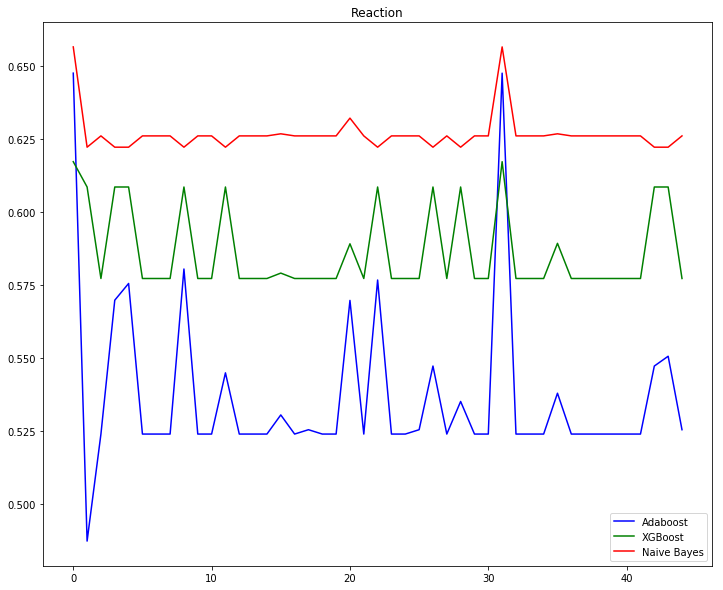

In [171]:
performances[2,0:n]

array([0.65667828, 0.62232905, 0.6261959 , 0.62232905, 0.62232905,
       0.6261959 , 0.6261959 , 0.6261959 , 0.62232905, 0.6261959 ,
       0.6261959 , 0.62232905, 0.6261959 , 0.6261959 , 0.6261959 ,
       0.62691279, 0.6261959 , 0.6261959 , 0.6261959 , 0.6261959 ,
       0.63228216, 0.6261959 , 0.62232905, 0.6261959 , 0.6261959 ,
       0.6261959 , 0.62232905, 0.6261959 , 0.62232905, 0.6261959 ,
       0.6261959 , 0.65667828, 0.6261959 , 0.6261959 , 0.6261959 ,
       0.62691279, 0.6261959 , 0.6261959 , 0.6261959 , 0.6261959 ,
       0.6261959 , 0.6261959 , 0.62232905, 0.62232905, 0.6261959 ])

## Definition of classifiers

In [174]:
def best_params(classifier,param_grid,X,y):
    print(type(classifier).__name__,thing)
    for score in goal_metrics:
        print("# Tuning hyper-parameters for %s" %score)
        print()

        clf = GridSearchCV(classifier, param_grid, cv=5,
                           scoring='%s_macro' % score)
        clf.fit(X, y)

        print("Best parameters set found on development set:")
        print()
        print(clf.best_params_)
        print()
        print("Grid scores on development set:")
        print()
        means = clf.cv_results_['mean_test_score']
        stds = clf.cv_results_['std_test_score']
        #for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        #    print("%0.3f (+/-%0.03f) for %r"
        #          % (mean, std * 2, params))
        print()

        return clf.best_estimator_

In [175]:
grid_adaboost = {"base_estimator__criterion" : ["gini", "entropy"],
                  "base_estimator__splitter" :   ["best"],
                  "base_estimator__class_weight": ["balanced",None],
                  "n_estimators": [10,20,30,40,50]
                 }

grid_xgboost = { 
              'objective':['binary:logistic'],
              'learning_rate': [0.2], 
              'max_depth': [5,6,7],
              'booster': ['gbtree'],
              'n_estimators': [20,30,40],
              'scale_pos_weight':[1,ratio, 1/ratio]}
grid_knn = {'n_neighbors':[2,3,4,5,6,7,8,9,10]}

#best adaboost 
#{'base_estimator__class_weight': 'balanced', 'base_estimator__criterion': 'entropy', 'base_estimator__splitter': 'best', 'n_estimators': 30}
#best xgboost
#{'booster': 'gbtree', 'lambda': 0, 'learning_rate': 0.2, 'max_depth': 6, 'n_estimators': 30, 'objective': 'binary:logistic', 'scale_pos_weight': 0.4623314829500396}

In [176]:
def classification_report(thing_tried,classifier, X_test,y_test):
        print("STEP IN PIPELINE: ",thing_tried)
        print("Detailed classification report:")
        print()
        print("The model is trained on the full development set.")
        print("The scores are computed on the full evaluation set.")
        print()
        y_true, y_pred = y_test, classifier.predict(X_test)
        print("Classification report for classifier %s:\n%s\n"
        % (classifier, metrics.classification_report(y_true, y_pred)))
        print("Confusion matrix:\n%s" % metrics.confusion_matrix(y_true, y_pred))
        print("--------------------------")
        return [y_true, y_pred]

In [177]:
def report_classifiers(classifiers,X_test,y_test,step):
    for c in classifiers:
        classification_report(step,c,X_test,y_test)

## Classification

In [178]:
def train_classifiers(X_train,y_train):
    print("HYPER PARAMETER TUNING  *********************")
    adaboost_c = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1,))
    xgb_c = xgb.XGBClassifier()
    gnb_c = GaussianNB()
    knn_c = KNeighborsClassifier()
    
    adaboost_c = best_params(adaboost_c,grid_adaboost,X_train,y_train)
    xgb_c = best_params(xgb_c,grid_xgboost,X_train,y_train)   
    gnb_c.fit(X_train,y_train)
    knn_c = best_params(knn_c,grid_knn,X_train,y_train)
    classifiers =[adaboost_c,xgb_c,gnb_c,knn_c]
    print("END HYPERPARAMETER TUNING  *********************")

    return classifiers

In [163]:
#things_try = ['normal','scale','feture_selection','feature_extraction','ensemble','threshold']
things_try = ['normal','scale']

for thing in things_try:
    if(thing == 'normal'):    
        classifiers = train_classifiers(X_train,y_train)
        report_classifiers(classifiers,X_test,y_test,thing)
    if(thing == 'scale'):
        type_scale = "standard"
        [new_xtrain,new_xtest] = scaling_features(X_train,X_test,"standard")
        classifiers = train_classifiers(new_xtrain,y_train)
        report_classifiers(classifiers,new_xtest,y_test,thing+str(type_scale))
        
        type_scale = "minmax"
        [new_xtrain,new_xtest] = scaling_features(X_train,X_test,type_scale)
        classifiers = train_classifiers(new_xtrain,y_train)
        report_classifiers(classifiers,new_xtest,y_test,thing+str(type_scale))
    if(thing=="feture_selection"):
        #number of featrues to check
        n=45
        type_scale = "minmax"
        [new_xtrain,new_xtest] = scaling_features(X_train,X_test,type_scale)
        classifiers = train_classifiers(new_xtrain,y_train)
        get_feature_curves(classifiers, new_xtrain,y_train,new_xtest,y_test,n)
        
        

AdaBoostClassifier normal
# Tuning hyper-parameters for f1

Best parameters set found on development set:

{'base_estimator__class_weight': None, 'base_estimator__criterion': 'gini', 'base_estimator__splitter': 'best', 'n_estimators': 50}

Grid scores on development set:


XGBClassifier normal
# Tuning hyper-parameters for f1

Best parameters set found on development set:

{'booster': 'gbtree', 'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 20, 'objective': 'binary:logistic', 'scale_pos_weight': 0.42945736434108533}

Grid scores on development set:


KNeighborsClassifier normal
# Tuning hyper-parameters for f1

Best parameters set found on development set:

{'n_neighbors': 4}

Grid scores on development set:


normal
Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

Classification report for classifier AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class

/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


AdaBoostClassifier scale
# Tuning hyper-parameters for f1

Best parameters set found on development set:

{'base_estimator__class_weight': 'balanced', 'base_estimator__criterion': 'gini', 'base_estimator__splitter': 'best', 'n_estimators': 10}

Grid scores on development set:


XGBClassifier scale
# Tuning hyper-parameters for f1

Best parameters set found on development set:

{'booster': 'gbtree', 'learning_rate': 0.2, 'max_depth': 6, 'n_estimators': 20, 'objective': 'binary:logistic', 'scale_pos_weight': 0.42945736434108533}

Grid scores on development set:


KNeighborsClassifier scale
# Tuning hyper-parameters for f1

Best parameters set found on development set:

{'n_neighbors': 4}

Grid scores on development set:


scalestandard
Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

Classification report for classifier AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassi

## Learning curves and feature curves

In [196]:
#number of featrues to check
n=6
type_scale = "scalestandard"
[new_xtrain,new_xtest] = scaling_features(X_train,X_test,type_scale)
performance = get_feature_curves(new_xtrain,y_train,new_xtest,y_test,n)

SHAPE SELECTED FEATURES (1844, 1)
HYPER PARAMETER TUNING  *********************
AdaBoostClassifier scale
# Tuning hyper-parameters for f1

Best parameters set found on development set:

{'base_estimator__class_weight': 'balanced', 'base_estimator__criterion': 'gini', 'base_estimator__splitter': 'best', 'n_estimators': 30}

Grid scores on development set:


XGBClassifier scale
# Tuning hyper-parameters for f1



/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Best parameters set found on development set:

{'booster': 'gbtree', 'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 20, 'objective': 'binary:logistic', 'scale_pos_weight': 0.430566330488751}

Grid scores on development set:


KNeighborsClassifier scale
# Tuning hyper-parameters for f1

Best parameters set found on development set:

{'n_neighbors': 10}

Grid scores on development set:


END HYPERPARAMETER TUNING  *********************
SHAPE SELECTED FEATURES (1844, 2)
HYPER PARAMETER TUNING  *********************
AdaBoostClassifier scale
# Tuning hyper-parameters for f1

Best parameters set found on development set:

{'base_estimator__class_weight': None, 'base_estimator__criterion': 'gini', 'base_estimator__splitter': 'best', 'n_estimators': 50}

Grid scores on development set:


XGBClassifier scale
# Tuning hyper-parameters for f1

Best parameters set found on development set:

{'booster': 'gbtree', 'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 20, 'objective': 'binary:

/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


SHAPE SELECTED FEATURES (1844, 3)
HYPER PARAMETER TUNING  *********************
AdaBoostClassifier scale
# Tuning hyper-parameters for f1

Best parameters set found on development set:

{'base_estimator__class_weight': 'balanced', 'base_estimator__criterion': 'gini', 'base_estimator__splitter': 'best', 'n_estimators': 20}

Grid scores on development set:


XGBClassifier scale
# Tuning hyper-parameters for f1

Best parameters set found on development set:

{'booster': 'gbtree', 'learning_rate': 0.2, 'max_depth': 6, 'n_estimators': 20, 'objective': 'binary:logistic', 'scale_pos_weight': 0.430566330488751}

Grid scores on development set:


KNeighborsClassifier scale
# Tuning hyper-parameters for f1

Best parameters set found on development set:

{'n_neighbors': 10}

Grid scores on development set:


END HYPERPARAMETER TUNING  *********************
SHAPE SELECTED FEATURES (1844, 4)
HYPER PARAMETER TUNING  *********************
AdaBoostClassifier scale
# Tuning hyper-parameters for f1

Bes

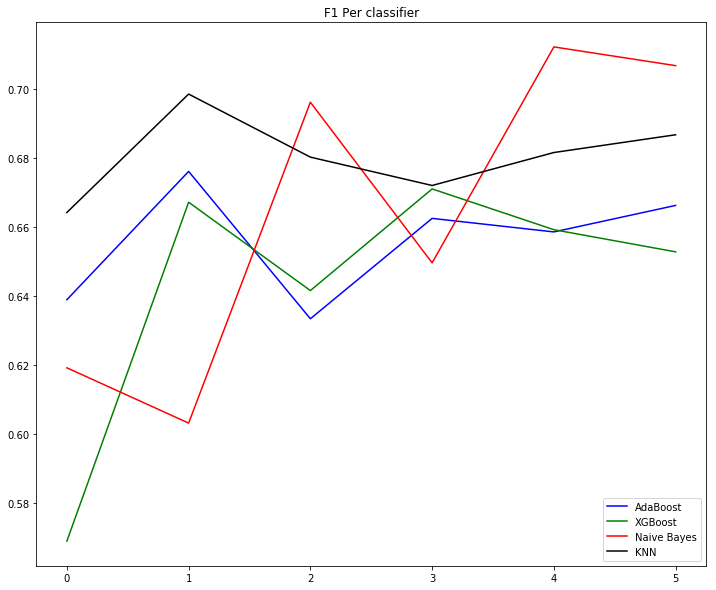

In [197]:
x_axis = np.arange(n) +1
plt.plot(x_axis,performance[0,0:n],'-b') 
plt.plot(np(n),performance[1,0:n],'-g') 
plt.plot(np.arange(n),performance[2,0:n],'-r') 
plt.plot(np.arange(n),performance[3,0:n],'-k') 

plt.title('F1 Per classifier') 
plt.legend(classifier_names, loc='lower right')
plt.show() 